In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import h5py 

In [0]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import h5py
import numpy as np
import pandas as pd

#TRAIN DATA
id = '1oLVjnnlTBxxX8OfRecVlanSlmdcA9fkm'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_128.h5')  

with h5py.File("train_128.h5",'r') as train_data: 
    train_data = np.copy(train_data['data'])
    
#TRAIN LABELS
id = '1RezpKoYEfht7eIFcZsO0FUZUXuJukmZV'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_label.h5')  

with h5py.File("train_label.h5",'r') as train_label:
    train_label = np.copy(train_label['label'])
    
#TEST DATA
id = '1E3r8QluNG5kqldIkAKlZRbORYLe7mHLP'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test_128.h5')  

with h5py.File("test_128.h5",'r') as test_data:
    test_data = np.copy(test_data['data'])

In [0]:
f1 = h5py.File('train_128.h5', 'r')
list(f1.keys())
X1 = f1['data']
X_full= np.array(X1.value)

In [0]:
f1 = h5py.File('train_label.h5', 'r')
list(f1.keys())
Y1 = f1['label']
Y_full= np.array(Y1.value)

In [0]:
def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

def normalize(X):
    mu_train = np.mean(X, axis=0,keepdims = True)
    var_train = np.var(X, axis=0,keepdims = True)
    X_norm = (X - mu_train) / np.sqrt(var_train)
    
    return X_norm, mu_train, var_train

def normalize_test(X,mu_train,var_train):
    X_norm = (X - mu_train) / np.sqrt(var_train)
    
    return X_norm

In [10]:
train_X = X_full[0:50000]
train_X, mu_train, var_train = normalize(train_X)
train_X = train_X.T

train_Y = Y_full[0:50000]
train_Y = oneHotIt(train_Y).T

dev_X = X_full[50000:]
dev_X = normalize_test(dev_X, mu_train, var_train)
dev_X = dev_X.T 

dev_Y = Y_full[50000:]
dev_Y = oneHotIt(dev_Y).T

print(train_X.shape)
print(train_Y.shape)
print(dev_X.shape)
print(dev_Y.shape)

(128, 50000)
(10, 50000)
(128, 10000)
(10, 10000)


In [0]:
def compute_cost(a3, Y):
    """
    Computes the cost
    
    Arguments:
    a3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    logits = a3.T
    labels = Y.T
    
    cost = -np.sum((np.log(np.sum(labels*logits,axis=1, keepdims=True))))/logits.shape[0]

    return cost

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1]. 
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """
    
    np.random.seed(3)
    parameters = {}
    bn_params = {}
    L = len(layer_dims) # number of layers in the network
    
    bn_params['bn1_mean'] = np.random.randn(layer_dims[1], 1)
    bn_params['bn1_var'] =  np.random.randn(layer_dims[1], 1)
    
    bn_params['bn2_mean'] = np.random.randn(layer_dims[2], 1)
    bn_params['bn2_var'] = np.random.randn(layer_dims[2], 1)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['g' + str(l)] = np.random.randn(layer_dims[l], 1) 
        parameters['b' + str(l)] = np.random.randn(layer_dims[l], 1)

    return parameters, bn_params

def forward_propagation(X, parameters, bn_params):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
    
    # retrieve parameters
    W1 = parameters["W1"]
    g1 = parameters["g1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    g2 = parameters["g2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    g3 = parameters["g3"]
    b3 = parameters["b3"]
    
    # LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> RELU -> LINEAR -> SOFTMAX
    z1 = np.dot(W1, X)
    norm1, cache1, mu1, var1 = batchnorm_forward(z1, g1, b1)
    a1 = relu(norm1)
    z2 = np.dot(W2, a1)
    norm2, cache2, mu2, var2 = batchnorm_forward(z2, g2, b2)
    a2 = relu(norm2)
    z3 = np.dot(W3, a2) + b3
    a3 = softmax(z3.T).T
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3, norm1,norm2,cache1,cache2)
    
    bn_params['bn1_mean'] = .9 * bn_params['bn1_mean'] + .1 * mu1
    bn_params['bn1_var'] = .9 * bn_params['bn1_var'] + .1 * var1
    
    bn_params['bn2_mean'] = .9 * bn_params['bn2_mean'] + .1 * mu2
    bn_params['bn2_var'] = .9 * bn_params['bn2_var'] + .1 * var2
    
    return a3, cache, bn_params

def forward_propagation_test(X, parameters, bn_params):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
    
    # retrieve parameters
    W1 = parameters["W1"]
    g1 = parameters["g1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    g2 = parameters["g2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    g3 = parameters["g3"]
    b3 = parameters["b3"]
    
    # LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> RELU -> LINEAR -> SOFTMAX
    z1 = np.dot(W1, X)
    norm1 = (z1 - bn_params['bn1_mean']) / np.sqrt(bn_params['bn1_var'] + 1e-8)
    norm1 = norm1 * g1 + b1
    a1 = relu(norm1)
    z2 = np.dot(W2, a1)
    norm2 = (z2 - bn_params['bn2_mean']) / np.sqrt(bn_params['bn2_var'] + 1e-8)
    norm2 = norm2 * g2 + b2
    a2 = relu(norm2)
    z3 = np.dot(W3, a2) + b3
    a3 = softmax(z3.T).T
    
    return a3

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3,norm1, norm2,cache1,cache2) = cache
    
    dz3 = a3 - Y
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dnorm2, dg2, db2 = batchnorm_backward(da2, cache2)
    dz2 = np.multiply(dnorm2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    
    da1 = np.dot(W2.T, dz2)
    dnorm1, dg1, db1 = batchnorm_backward(da1, cache1)
    dz1 = np.multiply(dnorm1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    
    #Not Used Parameters
    dg3 = np.zeros((10,1))
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3, "dg3": dg3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2, "dg2": dg2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1, "dg1": dg1,}
    
    return gradients

def predict(X, y, parameters,bn_params):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((10,m), dtype = np.int)
    accuracy = 0 
    
    # Forward propagation
    a3 = forward_propagation_test(X, parameters, bn_params)
    #print(a3[:,1])
    
    # convert probas to 0/1 predictions
    for j in range(0,10):
        for i in range(0, a3.shape[1]):
            if a3[j,i] == np.max(a3[:,i]):
                p[j,i] = 1
            else:
                p[j,i] = 0
    #print(p[:,1]) 
    #print(y[:,1])
    for i in range(0, a3.shape[1]):
        accuracy += (p[:,i] == y[:,i]).all()
    accuracy = accuracy/a3.shape[1]
    
    print(str(accuracy))
    
    return p


In [0]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3,norm1, norm2,cache1,cache2) = cache
    
    dz3 = a3 - Y
    dW3 = np.dot(dz3, a2.T) + W3*lambd/m
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dnorm2, dg2, db2 = batchnorm_backward(da2, cache2)
    dz2 = np.multiply(dnorm2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T) + W2*lambd/m
    
    da1 = np.dot(W2.T, dz2)
    dnorm1, dg1, db1 = batchnorm_backward(da1, cache1)
    dz1 = np.multiply(dnorm1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T) + W1*lambd/m
    
    #Not Used Parameters
    dg3 = np.zeros((10,1))
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3, "dg3": dg3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2, "dg2": dg2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1, "dg1": dg1,}
    
    return gradients

In [0]:
def forward_propagation_with_dropout(X, parameters, bn_params, keep_prob = 0.5):
    """    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    g1 = parameters["g1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    g2 = parameters["g2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    g3 = parameters["g3"]
    b3 = parameters["b3"]
    
    # LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> SOFTMAX
    Z1 = np.dot(W1, X)
    norm1, cache1, mu1, var1 = batchnorm_forward(Z1, g1, b1)
    A1 = relu(norm1)
    D1 = np.random.rand(A1.shape[0],A1.shape[1])      # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob)                             # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1*D1                                        # Step 3: shut down some neurons of A1
    A1 = A1/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down

    Z2 = np.dot(W2, A1)
    norm2, cache2, mu2, var2 = batchnorm_forward(Z2, g2, b2)
    A2 = relu(norm2)

    D2 = np.random.rand(A2.shape[0],A2.shape[1])       # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob)                              # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2*D2                                         # Step 3: shut down some neurons of A2
    A2 = A2/keep_prob                                  # Step 4: scale the value of neurons that haven't been shut down

    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3.T).T
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3, norm1,norm2,cache1,cache2)
    
    bn_params['bn1_mean'] = .9 * bn_params['bn1_mean'] + .1 * mu1
    bn_params['bn1_var'] = .9 * bn_params['bn1_var'] + .1 * var1
    
    bn_params['bn2_mean'] = .9 * bn_params['bn2_mean'] + .1 * mu2
    bn_params['bn2_var'] = .9 * bn_params['bn2_var'] + .1 * var2
    
    return A3, cache, bn_params

In [0]:
def backward_propagation_with_dropout_L2(X, Y, cache, keep_prob, lambd):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3, norm1,norm2,cache1,cache2) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + W3*lambd/m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2*D2                                     # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob                              # Step 2: Scale the value of neurons that haven't been shut down
    dnorm2, dg2, db2 = batchnorm_backward(dA2, cache2)
    dZ2 = np.multiply(dnorm2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + W2*lambd/m
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1*D1                                     # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob                              # Step 2: Scale the value of neurons that haven't been shut down
    dnorm1, dg1, db1 = batchnorm_backward(dA1, cache1)
    dZ1 = np.multiply(dnorm1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + W1*lambd/m
    
    #Not Used Parameters
    dg3 = np.zeros((10,1))
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dg3": dg3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2, "dg2": dg2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1, "dg1": dg1}
    
    return gradients

In [0]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3, norm1,norm2,cache1,cache2) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2*D2                                     # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob                              # Step 2: Scale the value of neurons that haven't been shut down
    dnorm2, dg2, db2 = batchnorm_backward(dA2, cache2)
    dZ2 = np.multiply(dnorm2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1*D1                                     # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob                              # Step 2: Scale the value of neurons that haven't been shut down
    dnorm1, dg1, db1 = batchnorm_backward(dA1, cache1)
    dZ1 = np.multiply(dnorm1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    
    #Not Used Parameters
    dg3 = np.zeros((10,1))
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dg3": dg3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2, "dg2": dg2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1, "dg1": dg1}
    
    return gradients

In [0]:
def batchnorm_forward(X, gamma, beta):
    mu = np.mean(X, axis=1,keepdims = True)
    var = np.var(X, axis=1,keepdims = True)

    X_norm = (X - mu) / np.sqrt(var + 1e-8)

    out = gamma * X_norm + beta

    cache = (X, X_norm, mu, var, gamma, beta)

    return out, cache, mu, var

In [0]:
def batchnorm_backward(dout, cache):
    X, X_norm, mu, var, gamma, beta = cache
    
    D, N = X.shape

    std_inv = 1. / np.sqrt(var + 1e-8)
    X_mu = X - mu
    dX_norm = dout * gamma
    dvar = np.sum(dX_norm * X_mu,axis=1,keepdims=True) * -0.5 * (var + 1e-8)**(-3/2)
    dmu = np.sum(dX_norm * -std_inv ,axis=1,keepdims=True) + dvar * 1/N * np.sum(-2.* X_mu, axis=1,keepdims=True)

    dX = (dX_norm * std_inv) + (dmu / N) + (dvar * 2/N * X_mu)
    dbeta = np.sum(dout,axis=1,keepdims=True)
    dgamma = np.sum(dout * X_norm, axis=1, keepdims=True)
    
    return dX, dgamma, dbeta

In [0]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 3 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*grads['db' + str(l+1)]
        parameters["g" + str(l+1)] = parameters['g' + str(l+1)] - learning_rate*grads['dg' + str(l+1)]
        
    return parameters

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 3 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        v["dg" + str(l+1)] = np.zeros(parameters['g' + str(l+1)].shape)
   
    return v

In [0]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 3 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
    
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)]+(1-beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)]+(1-beta)*grads['db' + str(l+1)]
        v["dg" + str(l+1)] = beta*v["dg" + str(l+1)]+(1-beta)*grads['dg' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v["db" + str(l+1)]
        parameters["g" + str(l+1)] = parameters["g" + str(l+1)]-learning_rate*v["dg" + str(l+1)]
     
    return parameters, v

In [0]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 3 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):

        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        v["dg" + str(l+1)] = np.zeros(parameters['g' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dg" + str(l+1)] = np.zeros(parameters['g' + str(l+1)].shape)
    
    return v, s

In [0]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 3                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".

        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)]+(1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)]+(1-beta1)*grads["db" + str(l+1)]
        v["dg" + str(l+1)] = beta1*v["dg" + str(l+1)]+(1-beta1)*grads["dg" + str(l+1)]
        
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**(t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-beta1**(t))
        v_corrected["dg" + str(l+1)] = v["dg" + str(l+1)]/(1-beta1**(t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*(grads["dW" + str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*(grads["db" + str(l+1)]**2)
        s["dg" + str(l+1)] = beta2*s["dg" + str(l+1)]+(1-beta2)*(grads["dg" + str(l+1)]**2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**(t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**(t))
        s_corrected["dg" + str(l+1)] = s["dg" + str(l+1)]/(1-beta2**(t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v_corrected["dW" + str(l+1)]/((s_corrected["dW" + str(l+1)])**(1/2)+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v_corrected["db" + str(l+1)]/((s_corrected["db" + str(l+1)])**(1/2)+epsilon)
        parameters["g" + str(l+1)] = parameters["g" + str(l+1)]-learning_rate*v_corrected["dg" + str(l+1)]/((s_corrected["dg" + str(l+1)])**(1/2)+epsilon)
        
    return parameters, v, s

In [0]:
def model(X, Y, layers_dims, optimizer, regularizer = "No",keep_prob = 0.85, lambd = 0.7, learning_rate_init = 0.0007, mini_batch_size = 100, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters, bn_params = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters) 
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        learning_rate = learning_rate_init
        #learning_rate = learning_rate_init  * (1 / (1 + 0.001 * i))
        #learning_rate = learning_rate_init  ** (i+1)
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            if regularizer == "DropOut":
                a3, caches, bn_params = forward_propagation_with_dropout(minibatch_X, parameters,bn_params,keep_prob)
            elif regularizer == "DropOut_L2":
                a3, caches, bn_params = forward_propagation_with_dropout(minibatch_X, parameters,bn_params,keep_prob)
            else:
                a3, caches, bn_params = forward_propagation(minibatch_X, parameters,bn_params)
                
            # Compute cost
            cost = compute_cost(a3, minibatch_Y)
            
            # Backward propagation
            if regularizer == "No":
                grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            elif regularizer == "L2":
                grads = backward_propagation_with_regularization(minibatch_X, minibatch_Y, caches,lambd)
            elif regularizer == "DropOut":
                grads = backward_propagation_with_dropout(minibatch_X, minibatch_Y, caches, keep_prob)
            elif regularizer == "DropOut_L2":
                grads = backward_propagation_with_dropout_L2(minibatch_X, minibatch_Y, caches, keep_prob, lambd)
                
            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 20 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 20 == 0:
            costs.append(cost)
                
    # plot the cost
    if print_cost:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 20)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

    return parameters, bn_params

In [23]:
# Find the best lambd and keep_prob
for i in (0.3,0.5,0.7,1):
    for j in (0,0.3,0.5,0.7,1): 
        layers_dims = [train_X.shape[0], 25, 12, 10]
        parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.0007,regularizer = "DropOut_L2", keep_prob = i, lambd = j,print_cost=False)

        # Predict
        print("keep_prob: " + str(i))
        print("lambd: " + str(j))
        print("Adam + Dropout")
        print("Training Accuarcy: ")
        predict(train_X, train_Y, parameters, bn_params)
        print("Test Accuarcy: ")
        predict(dev_X, dev_Y, parameters, bn_params)
        print()


keep_prob: 0.3
lambd: 0
Adam + Dropout
Training Accuarcy: 
0.48704
Test Accuarcy: 
0.489

keep_prob: 0.3
lambd: 0.3
Adam + Dropout
Training Accuarcy: 
0.50084
Test Accuarcy: 
0.4988

keep_prob: 0.3
lambd: 0.5
Adam + Dropout
Training Accuarcy: 
0.50682
Test Accuarcy: 
0.5049

keep_prob: 0.3
lambd: 0.7
Adam + Dropout
Training Accuarcy: 
0.51494
Test Accuarcy: 
0.5107

keep_prob: 0.3
lambd: 1
Adam + Dropout
Training Accuarcy: 
0.47088
Test Accuarcy: 
0.4646

keep_prob: 0.5
lambd: 0
Adam + Dropout
Training Accuarcy: 
0.66706
Test Accuarcy: 
0.6584

keep_prob: 0.5
lambd: 0.3
Adam + Dropout
Training Accuarcy: 
0.65564
Test Accuarcy: 
0.6448

keep_prob: 0.5
lambd: 0.5
Adam + Dropout
Training Accuarcy: 
0.65716
Test Accuarcy: 
0.6457

keep_prob: 0.5
lambd: 0.7
Adam + Dropout
Training Accuarcy: 
0.65568
Test Accuarcy: 
0.645

keep_prob: 0.5
lambd: 1
Adam + Dropout
Training Accuarcy: 
0.6546
Test Accuarcy: 
0.6443

keep_prob: 0.7
lambd: 0
Adam + Dropout
Training Accuarcy: 
0.76012
Test Accuarcy:

In [24]:
# Find the best batch size
for i in (500,1000,2500,4000,5000):
        layers_dims = [train_X.shape[0], 25, 12, 10]
        parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 500,mini_batch_size = i,learning_rate_init = 0.0007,regularizer = "DropOut_L2", keep_prob = 1, lambd = 0.3,print_cost=False)

        # Predict
        print("batch size: " + str(i))
        print("Adam + Dropout")
        print("Training Accuarcy: ")
        predict(train_X, train_Y, parameters, bn_params)
        print("Test Accuarcy: ")
        predict(dev_X, dev_Y, parameters, bn_params)
        print()

batch size: 500
Adam + Dropout
Training Accuarcy: 
0.83266
Test Accuarcy: 
0.8161

batch size: 1000
Adam + Dropout
Training Accuarcy: 
0.85438
Test Accuarcy: 
0.8374

batch size: 2500
Adam + Dropout
Training Accuarcy: 
0.87208
Test Accuarcy: 
0.8537

batch size: 4000
Adam + Dropout
Training Accuarcy: 
0.87668
Test Accuarcy: 
0.8569

batch size: 5000
Adam + Dropout
Training Accuarcy: 
0.88094
Test Accuarcy: 
0.8614



In [25]:
# Find the best learning Rate
for i in (0.0004,0.00045,0.0005,0.0006):
        layers_dims = [train_X.shape[0], 25, 12, 10]
        parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = i,regularizer = "DropOut_L2", keep_prob = 0.7, lambd = 0.3,print_cost=False)

        # Predict
        print("Learning Rate: " + str(i))
        print("Adam + L2")
        print("Training Accuarcy: ")
        predict(train_X, train_Y, parameters, bn_params)
        print("Test Accuarcy: ")
        predict(dev_X, dev_Y, parameters, bn_params)
        print()

Learning Rate: 0.0004
Adam + L2
Training Accuarcy: 
0.80716
Test Accuarcy: 
0.7964

Learning Rate: 0.00045
Adam + L2
Training Accuarcy: 
0.80288
Test Accuarcy: 
0.7883

Learning Rate: 0.0005
Adam + L2
Training Accuarcy: 
0.79328
Test Accuarcy: 
0.7793

Learning Rate: 0.0006
Adam + L2
Training Accuarcy: 
0.78154
Test Accuarcy: 
0.7682



Cost after epoch 0: 3.640002
Cost after epoch 20: 2.258537
Cost after epoch 40: 1.677940
Cost after epoch 60: 1.349982
Cost after epoch 80: 1.111361
Cost after epoch 100: 1.007836
Cost after epoch 120: 0.943676
Cost after epoch 140: 0.900678
Cost after epoch 160: 0.856154
Cost after epoch 180: 0.841031
Cost after epoch 200: 0.785969
Cost after epoch 220: 0.781769
Cost after epoch 240: 0.751804
Cost after epoch 260: 0.738625
Cost after epoch 280: 0.735861
Cost after epoch 300: 0.703663
Cost after epoch 320: 0.720678
Cost after epoch 340: 0.684282
Cost after epoch 360: 0.665684
Cost after epoch 380: 0.662597
Cost after epoch 400: 0.687923
Cost after epoch 420: 0.692763
Cost after epoch 440: 0.658270
Cost after epoch 460: 0.698061
Cost after epoch 480: 0.673186


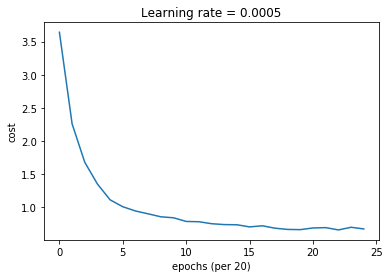

Adam + Dropout with Weight Decay
Training Accuarcy: 
0.82618
Test Accuarcy: 
0.8084

Cost after epoch 0: 2.875490
Cost after epoch 20: 2.470937
Cost after epoch 40: 2.494797
Cost after epoch 60: 2.482702
Cost after epoch 80: 2.527551
Cost after epoch 100: 2.474166
Cost after epoch 120: 2.445984
Cost after epoch 140: 2.443725
Cost after epoch 160: 2.480417
Cost after epoch 180: 2.513272
Cost after epoch 200: 2.480626
Cost after epoch 220: 2.405390
Cost after epoch 240: 2.476589
Cost after epoch 260: 2.485560
Cost after epoch 280: 2.435484
Cost after epoch 300: 2.443321
Cost after epoch 320: 2.445272
Cost after epoch 340: 2.401845
Cost after epoch 360: 2.441451
Cost after epoch 380: 2.394491
Cost after epoch 400: 2.449274
Cost after epoch 420: 2.406354
Cost after epoch 440: 2.411751
Cost after epoch 460: 2.378066
Cost after epoch 480: 2.376381


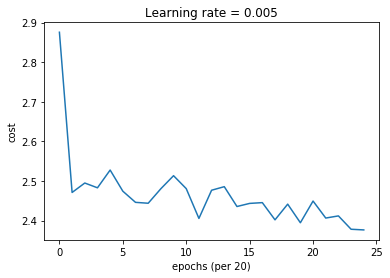

Minibatch GD with Momentum + Dropout with Weight Decay
Training Accuarcy: 
0.09954
Test Accuarcy: 
0.1023

Cost after epoch 0: 3.727488
Cost after epoch 20: 2.666400
Cost after epoch 40: 2.643143
Cost after epoch 60: 2.628610
Cost after epoch 80: 2.622343
Cost after epoch 100: 2.623746
Cost after epoch 120: 2.621473
Cost after epoch 140: 2.622549
Cost after epoch 160: 2.613964
Cost after epoch 180: 2.619143
Cost after epoch 200: 2.617566
Cost after epoch 220: 2.615306
Cost after epoch 240: 2.612831
Cost after epoch 260: 2.619734
Cost after epoch 280: 2.619042
Cost after epoch 300: 2.621649
Cost after epoch 320: 2.616562
Cost after epoch 340: 2.617454
Cost after epoch 360: 2.620403
Cost after epoch 380: 2.615266
Cost after epoch 400: 2.618628
Cost after epoch 420: 2.617816
Cost after epoch 440: 2.614302
Cost after epoch 460: 2.611800
Cost after epoch 480: 2.614112


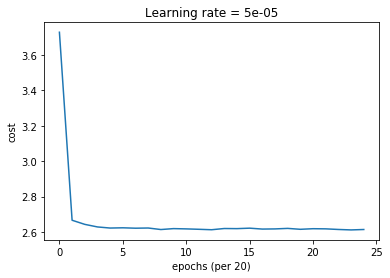

GD + Dropout with Weight Decay
Training Accuarcy: 
0.1152
Test Accuarcy: 
0.1173



In [26]:
# train 3-layer model - Adam + Dropout_L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.0005,regularizer = "DropOut_L2",keep_prob=0.85, lambd=0.3)

# Predict
print("Adam + Dropout with Weight Decay")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - Minibatch GD with Momentum + Dropout_L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "momentum",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.005,regularizer = "DropOut_L2",keep_prob=0.85, lambd=0.3)

# Predict
print("Minibatch GD with Momentum + Dropout with Weight Decay")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - GD + Dropout_L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "gd",num_epochs = 500,mini_batch_size = 50000,learning_rate_init = 0.00005,regularizer = "DropOut_L2",keep_prob=0.85, lambd=0.3)

# Predict
print("GD + Dropout with Weight Decay")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()

Cost after epoch 0: 3.640004
Cost after epoch 20: 2.259076
Cost after epoch 40: 1.676783
Cost after epoch 60: 1.350108
Cost after epoch 80: 1.113400
Cost after epoch 100: 1.010431
Cost after epoch 120: 0.946372
Cost after epoch 140: 0.903155
Cost after epoch 160: 0.858122
Cost after epoch 180: 0.842089
Cost after epoch 200: 0.785985
Cost after epoch 220: 0.781261
Cost after epoch 240: 0.751524
Cost after epoch 260: 0.737056
Cost after epoch 280: 0.732876
Cost after epoch 300: 0.703815
Cost after epoch 320: 0.718877
Cost after epoch 340: 0.685072
Cost after epoch 360: 0.663575
Cost after epoch 380: 0.664541
Cost after epoch 400: 0.688225
Cost after epoch 420: 0.690494
Cost after epoch 440: 0.655851
Cost after epoch 460: 0.693964
Cost after epoch 480: 0.670784
Cost after epoch 500: 0.665673
Cost after epoch 520: 0.681870
Cost after epoch 540: 0.656965
Cost after epoch 560: 0.652799
Cost after epoch 580: 0.686037


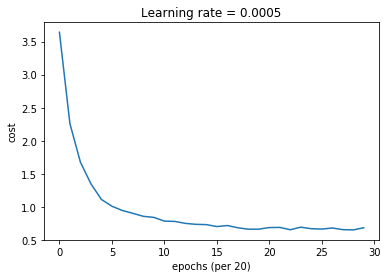

Adam + Dropout
Training Accuarcy: 
0.81718
Test Accuarcy: 
0.7981

Cost after epoch 0: 2.875490
Cost after epoch 20: 2.470318
Cost after epoch 40: 2.493587
Cost after epoch 60: 2.481960
Cost after epoch 80: 2.530878
Cost after epoch 100: 2.478328
Cost after epoch 120: 2.448864
Cost after epoch 140: 2.442475
Cost after epoch 160: 2.480577
Cost after epoch 180: 2.507188
Cost after epoch 200: 2.485358
Cost after epoch 220: 2.419151
Cost after epoch 240: 2.503104
Cost after epoch 260: 2.494246
Cost after epoch 280: 2.442707
Cost after epoch 300: 2.448919
Cost after epoch 320: 2.450110
Cost after epoch 340: 2.418452
Cost after epoch 360: 2.440393
Cost after epoch 380: 2.395809
Cost after epoch 400: 2.420361
Cost after epoch 420: 2.377538
Cost after epoch 440: 2.375814
Cost after epoch 460: 2.364324
Cost after epoch 480: 2.362397


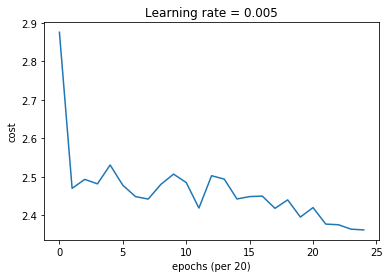

Minibatch GD with Momentum + Dropout
Training Accuarcy: 
0.09954
Test Accuarcy: 
0.1023

Cost after epoch 0: 3.727488
Cost after epoch 20: 2.666400
Cost after epoch 40: 2.643143
Cost after epoch 60: 2.628610
Cost after epoch 80: 2.622343
Cost after epoch 100: 2.623746
Cost after epoch 120: 2.621473
Cost after epoch 140: 2.622549
Cost after epoch 160: 2.613964
Cost after epoch 180: 2.619143
Cost after epoch 200: 2.617566
Cost after epoch 220: 2.615306
Cost after epoch 240: 2.612831
Cost after epoch 260: 2.619734
Cost after epoch 280: 2.619042
Cost after epoch 300: 2.621649
Cost after epoch 320: 2.616562
Cost after epoch 340: 2.617454
Cost after epoch 360: 2.620403
Cost after epoch 380: 2.615266
Cost after epoch 400: 2.618628
Cost after epoch 420: 2.617816
Cost after epoch 440: 2.614302
Cost after epoch 460: 2.611800
Cost after epoch 480: 2.614112


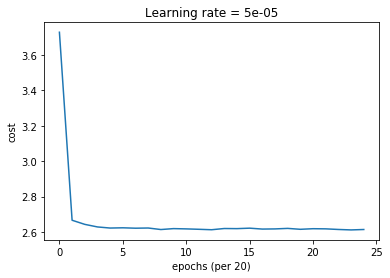

GD + Dropout
Training Accuarcy: 
0.1152
Test Accuarcy: 
0.1173



In [27]:
# train 3-layer model - Adam + Dropout
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 599,mini_batch_size = 5000,learning_rate_init = 0.0005,regularizer = "DropOut_L2",keep_prob=0.85, lambd=0)

# Predict
print("Adam + Dropout")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - Minibatch SGD with Momentum + Dropout
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "momentum",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.005,regularizer = "DropOut_L2",keep_prob=0.85, lambd=0)

# Predict
print("Minibatch GD with Momentum + Dropout")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - GD + Dropout
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "gd",num_epochs = 500,mini_batch_size = 50000,learning_rate_init = 0.00005,regularizer = "DropOut_L2",keep_prob=0.85, lambd=0)

# Predict
print("GD + Dropout")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y,parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y,parameters, bn_params)
print()

Cost after epoch 0: 3.474940
Cost after epoch 20: 1.884874
Cost after epoch 40: 1.247098
Cost after epoch 60: 0.871228
Cost after epoch 80: 0.667783
Cost after epoch 100: 0.563098
Cost after epoch 120: 0.507617
Cost after epoch 140: 0.477358
Cost after epoch 160: 0.441943
Cost after epoch 180: 0.426327
Cost after epoch 200: 0.404641
Cost after epoch 220: 0.389637
Cost after epoch 240: 0.381119
Cost after epoch 260: 0.360227
Cost after epoch 280: 0.346507
Cost after epoch 300: 0.338738
Cost after epoch 320: 0.357796
Cost after epoch 340: 0.328338
Cost after epoch 360: 0.357687
Cost after epoch 380: 0.341506
Cost after epoch 400: 0.341259
Cost after epoch 420: 0.351044
Cost after epoch 440: 0.342452
Cost after epoch 460: 0.345498
Cost after epoch 480: 0.338315


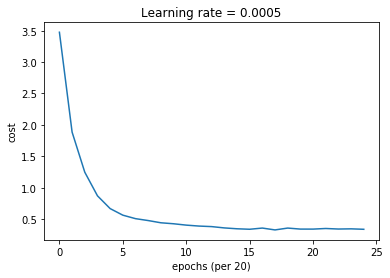

Adam +  Weight Decay
Training Accuarcy: 
0.88244
Test Accuarcy: 
0.8619

Cost after epoch 0: 2.685934
Cost after epoch 20: 2.625901
Cost after epoch 40: 2.316318
Cost after epoch 60: 2.296770
Cost after epoch 80: 2.310962
Cost after epoch 100: 2.169721
Cost after epoch 120: 2.149786
Cost after epoch 140: 3.083998
Cost after epoch 160: 2.142214
Cost after epoch 180: 1.884067
Cost after epoch 200: 2.187943
Cost after epoch 220: 1.703043
Cost after epoch 240: 1.615550
Cost after epoch 260: 0.950277
Cost after epoch 280: 0.744820
Cost after epoch 300: 1.132748
Cost after epoch 320: 1.290322
Cost after epoch 340: 1.844333
Cost after epoch 360: 1.593782
Cost after epoch 380: 0.985196
Cost after epoch 400: 0.833735
Cost after epoch 420: 3.916703
Cost after epoch 440: 1.036103
Cost after epoch 460: 0.741228
Cost after epoch 480: 4.886369


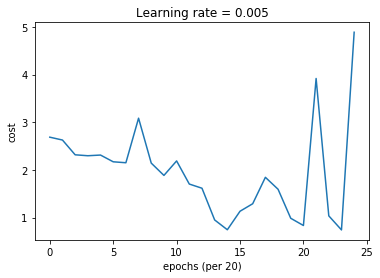

Minibatch GD with Momentum +  Weight Decay
Training Accuarcy: 
0.10024
Test Accuarcy: 
0.0988

Cost after epoch 0: 3.580234
Cost after epoch 20: 2.552890
Cost after epoch 40: 2.502598
Cost after epoch 60: 2.464973
Cost after epoch 80: 2.435043
Cost after epoch 100: 2.415641
Cost after epoch 120: 2.419365
Cost after epoch 140: 2.449762
Cost after epoch 160: 2.423457
Cost after epoch 180: 2.380041
Cost after epoch 200: 2.361536
Cost after epoch 220: 2.351802
Cost after epoch 240: 2.347090
Cost after epoch 260: 2.343353
Cost after epoch 280: 2.339950
Cost after epoch 300: 2.336993
Cost after epoch 320: 2.338522
Cost after epoch 340: 2.370463
Cost after epoch 360: 2.387342
Cost after epoch 380: 2.401364
Cost after epoch 400: 2.398605
Cost after epoch 420: 2.388486
Cost after epoch 440: 2.376276
Cost after epoch 460: 2.366272
Cost after epoch 480: 2.362971


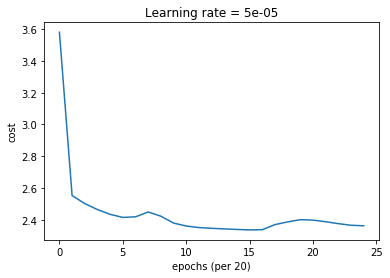

GD + Weight Decay
Training Accuarcy: 
0.14334
Test Accuarcy: 
0.1419



In [26]:
# train 3-layer model - Adam + L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.0005,regularizer = "DropOut_L2",keep_prob=1, lambd=0.3)

# Predict
print("Adam +  Weight Decay")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - Minibatch SGD with Momentum + L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "momentum",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.005,regularizer = "DropOut_L2",keep_prob=1, lambd=0.3)

# Predict
print("Minibatch GD with Momentum +  Weight Decay")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - GD + L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "gd",num_epochs = 500,mini_batch_size = 50000,learning_rate_init = 0.00005,regularizer = "DropOut_L2",keep_prob=1, lambd=0.3)

# Predict
print("GD + Weight Decay")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()

Cost after epoch 0: 3.474917
Cost after epoch 20: 1.885286
Cost after epoch 40: 1.245476
Cost after epoch 60: 0.870017
Cost after epoch 80: 0.667522
Cost after epoch 100: 0.563513
Cost after epoch 120: 0.507874
Cost after epoch 140: 0.477479
Cost after epoch 160: 0.441786
Cost after epoch 180: 0.427030
Cost after epoch 200: 0.404590
Cost after epoch 220: 0.390412
Cost after epoch 240: 0.381199
Cost after epoch 260: 0.360849
Cost after epoch 280: 0.346811
Cost after epoch 300: 0.339214
Cost after epoch 320: 0.359223
Cost after epoch 340: 0.330384
Cost after epoch 360: 0.357034
Cost after epoch 380: 0.340754
Cost after epoch 400: 0.341288
Cost after epoch 420: 0.353073
Cost after epoch 440: 0.342336
Cost after epoch 460: 0.343810
Cost after epoch 480: 0.337978


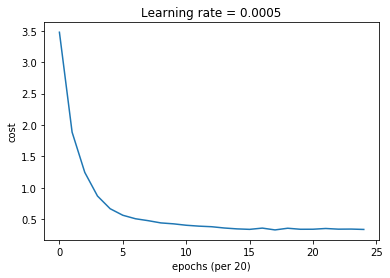

Adam
Training Accuarcy: 
0.88232
Test Accuarcy: 
0.8611

Cost after epoch 0: 2.398424


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Cost after epoch 20: inf
Cost after epoch 40: inf
Cost after epoch 60: inf
Cost after epoch 80: inf
Cost after epoch 100: inf
Cost after epoch 120: inf
Cost after epoch 140: inf
Cost after epoch 160: inf


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in greater


Cost after epoch 180: nan
Cost after epoch 200: nan
Cost after epoch 220: nan
Cost after epoch 240: nan
Cost after epoch 260: nan
Cost after epoch 280: nan
Cost after epoch 300: nan
Cost after epoch 320: nan
Cost after epoch 340: nan
Cost after epoch 360: nan
Cost after epoch 380: nan
Cost after epoch 400: nan
Cost after epoch 420: nan
Cost after epoch 440: nan
Cost after epoch 460: nan
Cost after epoch 480: nan


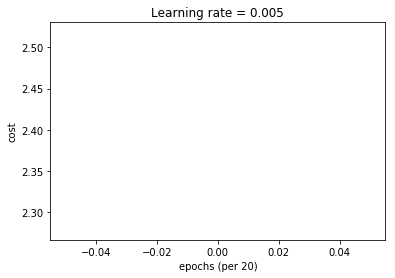

Minibatch GD with Momentum
Training Accuarcy: 
0.0
Test Accuarcy: 
0.0

Cost after epoch 0: 3.580234
Cost after epoch 20: 0.801505
Cost after epoch 40: 0.575429
Cost after epoch 60: 0.527251
Cost after epoch 80: 0.474485
Cost after epoch 100: 0.442043
Cost after epoch 120: 1.829594
Cost after epoch 140: 1.041975
Cost after epoch 160: 0.822350
Cost after epoch 180: 0.743373
Cost after epoch 200: 0.545017
Cost after epoch 220: 0.495616
Cost after epoch 240: 0.581697
Cost after epoch 260: 0.630993
Cost after epoch 280: 1.179127
Cost after epoch 300: 0.882243
Cost after epoch 320: 1.608914
Cost after epoch 340: 1.380603
Cost after epoch 360: 1.857321
Cost after epoch 380: 1.312346
Cost after epoch 400: 1.483992
Cost after epoch 420: 1.594168
Cost after epoch 440: 1.091601
Cost after epoch 460: 0.964355
Cost after epoch 480: 1.436358


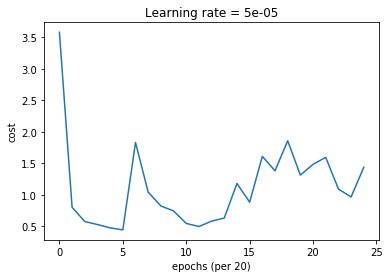

GD
Training Accuarcy: 
0.11942
Test Accuarcy: 
0.1152



In [29]:
# train 3-layer model - Adam 
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.0005,regularizer = "No",keep_prob=0.7, lambd=0.7)

# Predict
print("Adam")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - Minibatch SGD with Momentum 
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "momentum",num_epochs = 500,mini_batch_size = 5000,learning_rate_init = 0.005,regularizer = "No",keep_prob=0.7, lambd=0.7)

# Predict
print("Minibatch GD with Momentum")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - GD 
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "gd",num_epochs = 500,mini_batch_size = 50000,learning_rate_init = 0.00005,regularizer = "No",keep_prob=0.7, lambd=0.7)

# Predict
print("GD")
print("Training Accuarcy: ")
prediction = predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
prediction = predict(dev_X, dev_Y, parameters, bn_params)
print()